<a href="https://colab.research.google.com/github/hy-e/2025-ai-expert/blob/main/%EB%B9%84%EC%A0%84/%EC%A3%BC%ED%95%9C%EB%B3%84%EA%B5%90%EC%88%98%EB%8B%98/camera_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Camera Model

카메라 모델은 간단히 다음 두가지 변환으로 이루어져있습니다. (lens distortion 제외)
1. Camera Extrinsic Parameters
- world coordinate 상에서 camera coordinate으로의 변환
$$X_{cam} = RX_{world}+t=\begin{bmatrix}
R&|&t
\end{bmatrix}\begin{bmatrix}
X_{world}\\1
\end{bmatrix}$$
$$C_{world}=-R^Tt$$

2. Camera Intrinsic Parameters
- 3D -> image plane, image plane에서 우리가 원하는 이미지로의 변환

$$
\begin{pmatrix}
 fX+Zp_x\\fY+Zp_y\\Z
\end{pmatrix}=\begin{bmatrix}
f&&p_x&0\\
&f&p_y&0\\
&&1&0
\end{bmatrix}\begin{pmatrix}
 X\\Y\\Z\\1
\end{pmatrix}=\begin{bmatrix}
f&&p_x\\
&f&p_y\\
&&1
\end{bmatrix}\begin{bmatrix}
1&&&0\\
&1&&0\\
&&1&0
\end{bmatrix}\begin{pmatrix}
 X\\Y\\Z\\1
\end{pmatrix}
$$

Change to pixel
$$
\begin{bmatrix}
α_x&&p_x\\
&α_y&p_y\\
&&1
\end{bmatrix}
$$
$α_x = m_xf$
$α_y = m_yf$

where $p_x$, $p_y$ is principal point in image space and assume square pixels\
where $m_x$, $m_y$ convert to pixel


Reference\
https://colab.research.google.com/github/facebookresearch/pytorch3d/blob/stable/docs/tutorials/render_textured_meshes.ipynb#scrollTo=musUWTglgxSB

https://pytorch3d.org/docs/cameras

# Install and import module

In [ ]:
!pip install pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    Textures,
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object.

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesUV** is an auxiliary datastructure for storing vertex uv and texture maps for meshes.

**Meshes** has several class methods which are used throughout the rendering pipeline.

In [ ]:
# If running this notebook using Google Colab, run the following cell to fetch the mesh obj and texture files and save it at the path data/cow_mesh:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

## 2. Create a renderer

In this example we will first create a renderer which uses a perspective camera, a point light and applies Phong shading

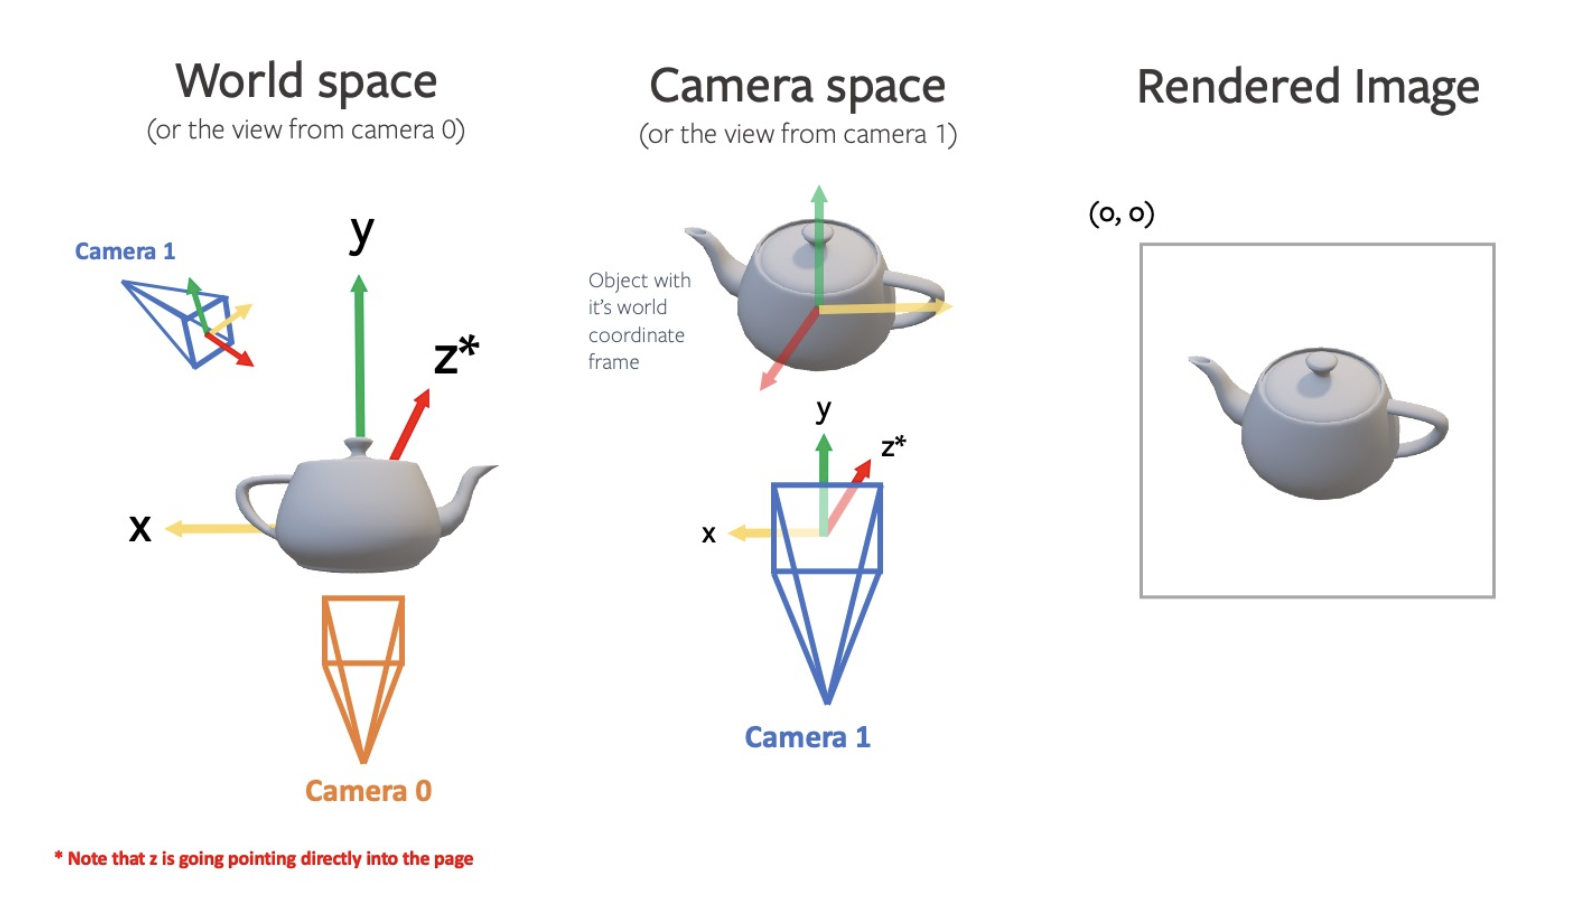

## 3. Render the mesh

The light is in front of the object so it is bright and the image has specular highlights.

In [ ]:
R = torch.eye(3).unsqueeze(dim=0).float()
T = torch.tensor([[0,0,3]]).float()

cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# About the azimuth angle and elevation, please refer to https://www.photopills.com/articles/understanding-azimuth-and-elevation

# Base setting for rasterization
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");


## Camera Center


$$X_{cam}=RX_{world}+T$$
$$C_{cam}=RC_{world}+T$$
$$(0,0,0)^{T}=RC_{world}+T$$
$$C_{world} = -R^TT$$


## Let's rotate the camera


In [ ]:
from pytorch3d.transforms import *
import numpy as np
from PIL import Image, ImageFont, ImageDraw

# setting for rasterization
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# TODO: Define a list of angles for camera rotation
# From [0, 0, 0], we will rotate the camera around the y-axis with 30 degree increments to [0, 360, 0]
angle_list =

image_list = []

font = ImageFont.load_default()

for angle in angle_list:
    # Camera rotation
    rad_degs = torch.deg2rad(torch.tensor([angle]).float())
    R = euler_angles_to_matrix(rad_degs, convention="XYZ")
    T = torch.tensor([[0, 0, 3]]).float()

    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )

    # TODO: Get the camera center location in world coordinates
    C_w =

    images = renderer(mesh)
    image = images[0, ..., :3].cpu().numpy()
    image = (image * 255).astype(np.uint8)  # convert to uint8 for PIL
    pil_image = Image.fromarray(image)

    draw = ImageDraw.Draw(pil_image)
    text = f"Angle: {angle}\nCw: {C_w}"
    draw.text((10, 10), text, font=font, fill=(0, 0, 0))

    image_list.append(pil_image)

# concatenate the images horizontally
total_width = sum(img.width for img in image_list)
max_height = max(img.height for img in image_list)
concatenated_image = Image.new('RGB', (total_width, max_height))

x_offset = 0
for img in image_list:
    concatenated_image.paste(img, (x_offset, 0))
    x_offset += img.width

plt.figure(figsize=(20, 10))
plt.imshow(np.asarray(concatenated_image))
plt.axis("off")
plt.show()